In [42]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

from statsforecast import StatsForecast
from statsforecast.models import ARIMA, AutoARIMA

from utilsforecast.losses import *
from utilsforecast.evaluation import evaluate

warnings.filterwarnings("ignore")
os.environ["NIXTLA_ID_AS_COL"] = "true"
pd.set_option('display.precision', 3)

In [43]:
plt.rcParams['figure.figsize'] = (9,6)

In [64]:
url = "https://raw.githubusercontent.com/marcopeix/TimeSeriesForecastingUsingFoundationModels/refs/heads/main/data/walmart_sales_small.csv"

df = pd.read_csv(url, parse_dates=["Date"])
df = df[['Store', 'Date', 'Weekly_Sales']]
df.head()

,Store,Date,Weekly_Sales
0,1,2010-02-05,1.644e+06
1,1,2010-02-12,1.642e+06
2,1,2010-02-19,1.612e+06
3,1,2010-02-26,1.410e+06
4,1,2010-03-05,1.555e+06


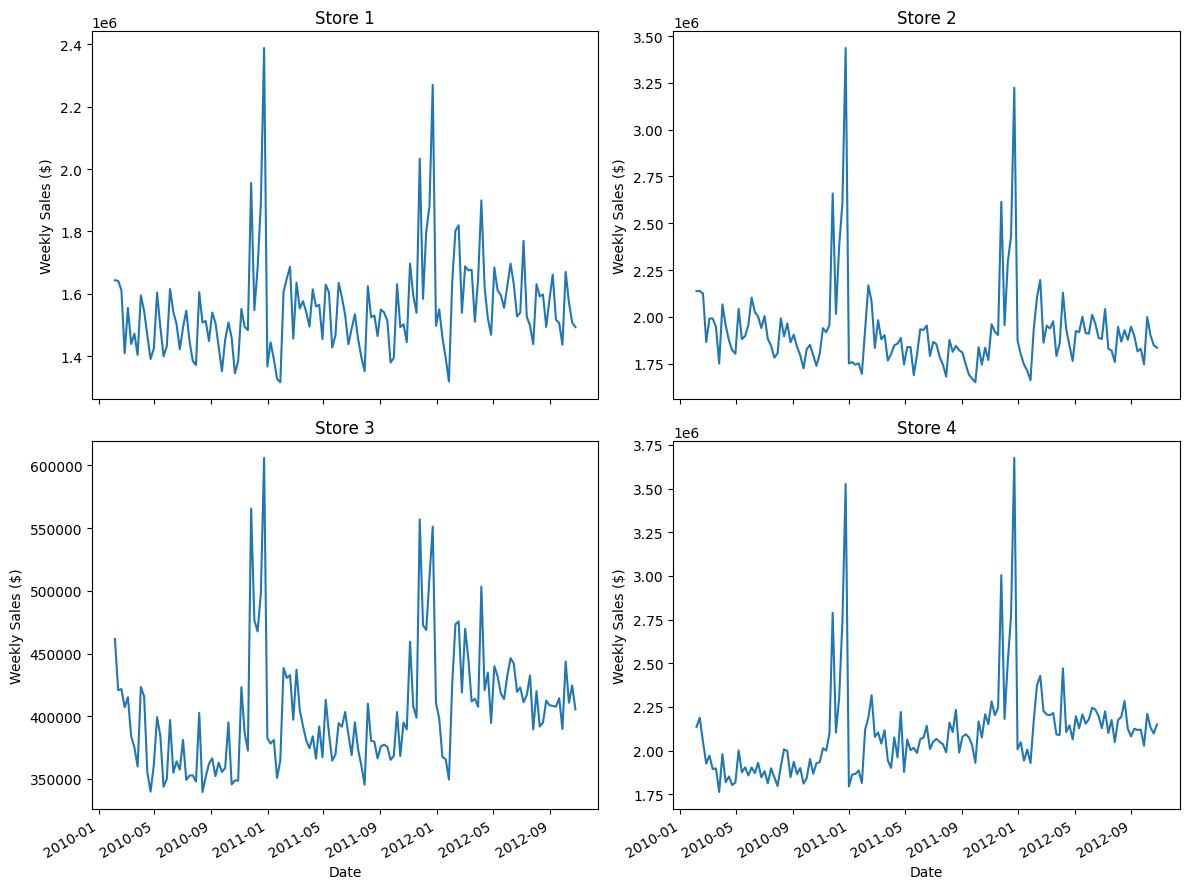

In [65]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,9))

for i, ax in enumerate(axes.flatten()):
    plot_df = df[df['Store'] == i+1]

    ax.plot(plot_df['Date'], plot_df['Weekly_Sales'])
    ax.set_title(f'Store {i+1}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Weekly Sales ($)')

fig.autofmt_xdate()
plt.tight_layout()

# Moving average - MA(q)

In [66]:
ma1 = np.array([1, 0.9])
ar1 = np.array([1, 0])

ma1_process = ArmaProcess(ar1, ma1).generate_sample(nsample=1000)

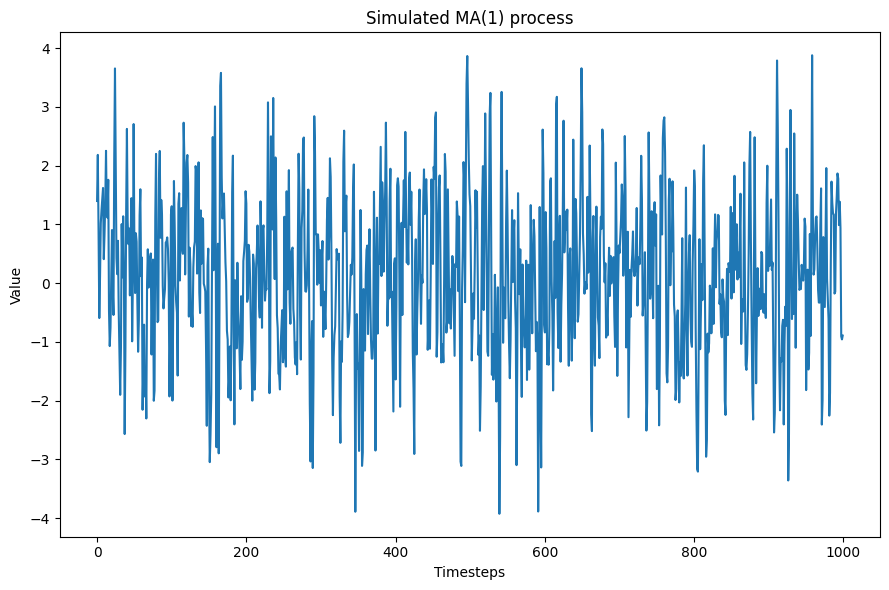

In [67]:
fig, ax = plt.subplots()

ax.plot(ma1_process)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.title('Simulated MA(1) process')

plt.tight_layout()

In [68]:
ADF_result = adfuller(ma1_process)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -7.586909694742066
p-value: 2.592149231761527e-11


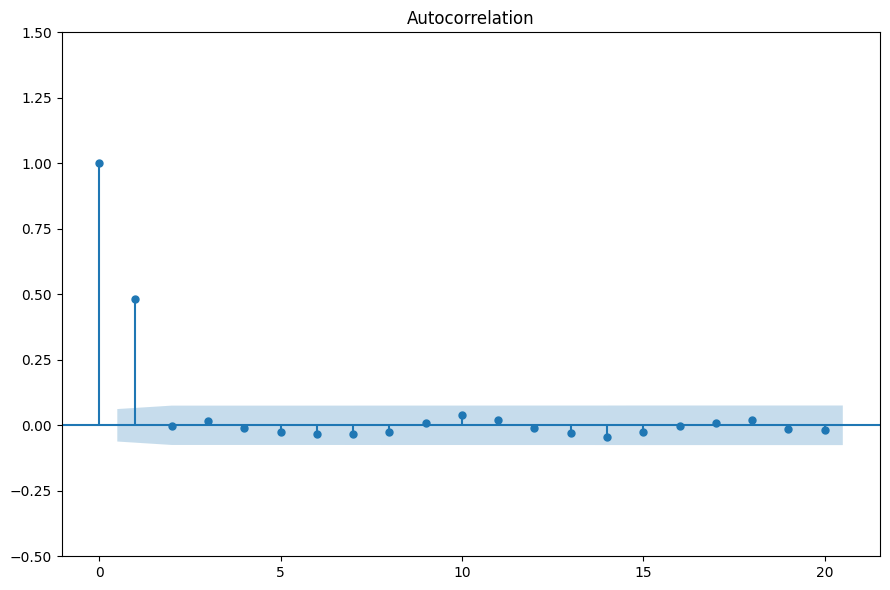

In [69]:
plot_acf(ma1_process, lags=20);

plt.ylim(-0.5, 1.5)
plt.tight_layout()

## Forecasting with MA(q)

In [70]:
store1_df = df.query("Store == 1")
diff_sales = np.diff(store1_df['Weekly_Sales'], n=1)

ADF_result = adfuller(diff_sales)

print(f'p-value: {ADF_result[1]}')

p-value: 1.676179669923014e-10


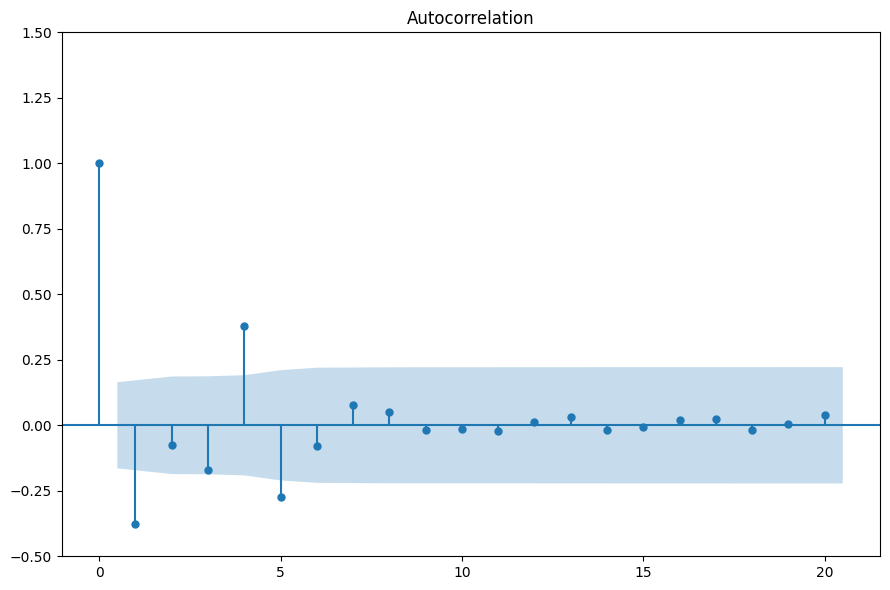

In [71]:
plot_acf(diff_sales, lags=20);

plt.ylim(-0.5, 1.5)
plt.tight_layout()

In [72]:
horizon = 4

ma_model = ARIMA(order=(0, 1, 1), season_length=1, alias='MA')

sf = StatsForecast(models=[ma_model], freq='W')
cv_df = sf.cross_validation(h=horizon, 
                            df=df, 
                            n_windows=10, 
                            step_size=horizon, 
                            level=[80], 
                            time_col='Date', 
                            id_col='Store', 
                            target_col='Weekly_Sales')

cv_df.head()

,Store,Date,cutoff,Weekly_Sales,MA,MA-lo-80,MA-hi-80
0,1,2012-01-27,2012-01-20,1.319e+06,1.606e+06,1.390e+06,1.823e+06
1,1,2012-02-03,2012-01-20,1.636e+06,1.606e+06,1.385e+06,1.827e+06
2,1,2012-02-10,2012-01-20,1.802e+06,1.606e+06,1.380e+06,1.832e+06
3,1,2012-02-17,2012-01-20,1.820e+06,1.606e+06,1.376e+06,1.837e+06
4,1,2012-02-24,2012-02-17,1.539e+06,1.654e+06,1.435e+06,1.873e+06


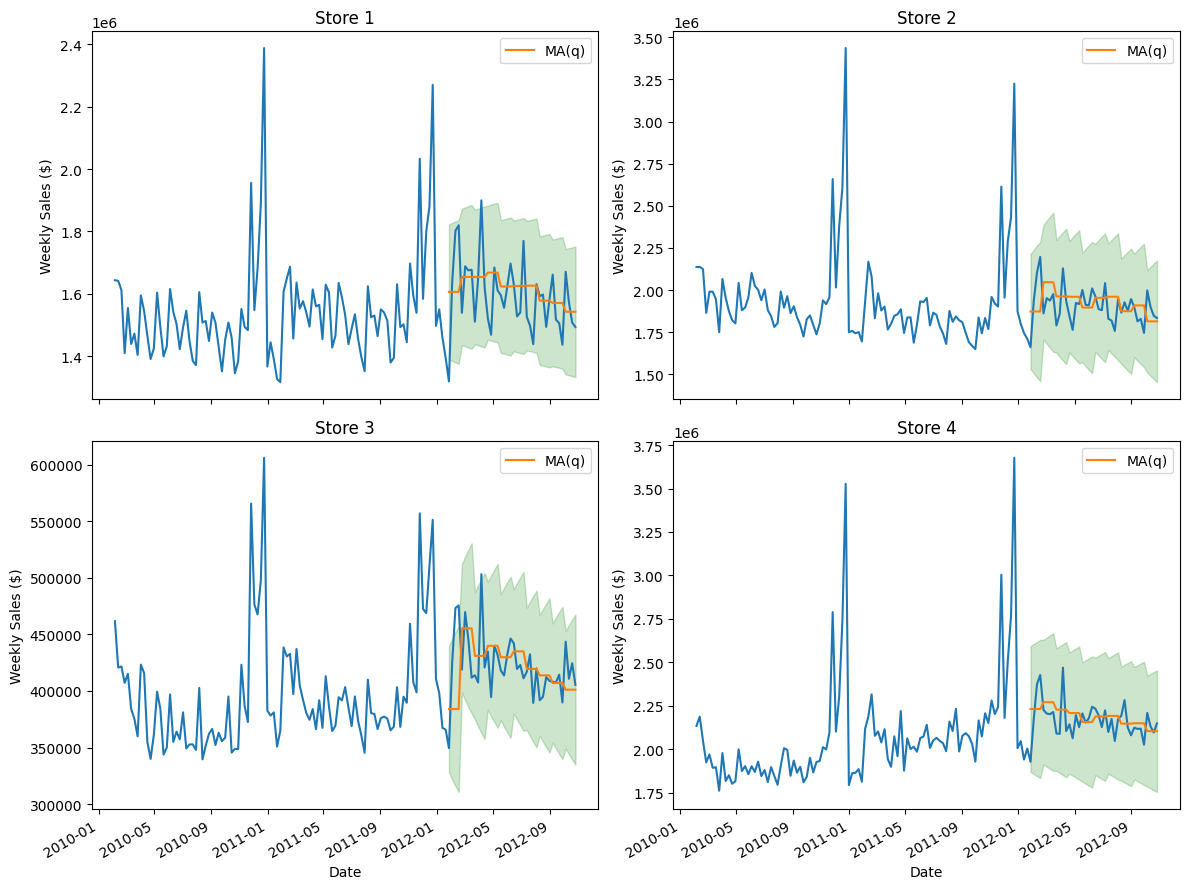

In [73]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,9))

for i, ax in enumerate(axes.flatten()):
    plot_df = df[df['Store'] == i+1]
    cv_plot_df = cv_df[cv_df['Store'] == i+1]

    ax.plot(plot_df['Date'], plot_df['Weekly_Sales'])
    ax.plot(cv_plot_df['Date'], cv_plot_df['MA'], label='MA(q)')
    ax.fill_between(cv_plot_df['Date'], cv_plot_df['MA-lo-80'], cv_plot_df['MA-hi-80'], color='green', alpha=0.2)
    ax.legend()
    ax.set_title(f'Store {i+1}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Weekly Sales ($)')

fig.autofmt_xdate()
plt.tight_layout()

In [74]:
eval_df = cv_df.drop(['Date', 'cutoff'], axis=1)
evaluation = evaluate(df=eval_df, metrics=[mae, smape], target_col='Weekly_Sales', id_col='Store')
evaluation

,Store,metric,MA
0,1,mae,84881.354
1,2,mae,98154.370
2,3,mae,21169.499
3,4,mae,78255.187
4,1,smape,0.027
5,2,smape,0.026
6,3,smape,0.025
7,4,smape,0.018


In [76]:
avg_evaluation = evaluation.drop(['Store'], axis=1).groupby('metric').mean().reset_index()
avg_evaluation

,metric,MA
0,mae,70615.102
1,smape,0.024


# Autoregressive model - AR(p)

In [77]:
np.random.seed(42)

ma2 = np.array([1, 0, 0])
ar2 = np.array([1, -0.33, -0.50])

AR2_process = ArmaProcess(ar2, ma2).generate_sample(nsample=1000)

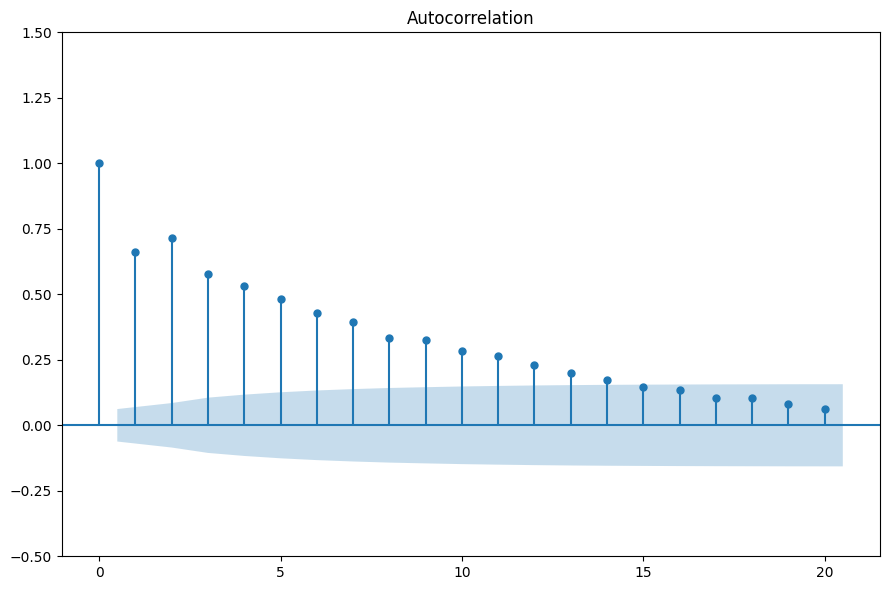

In [78]:
plot_acf(AR2_process, lags=20);

plt.ylim(-0.5, 1.5)
plt.tight_layout()

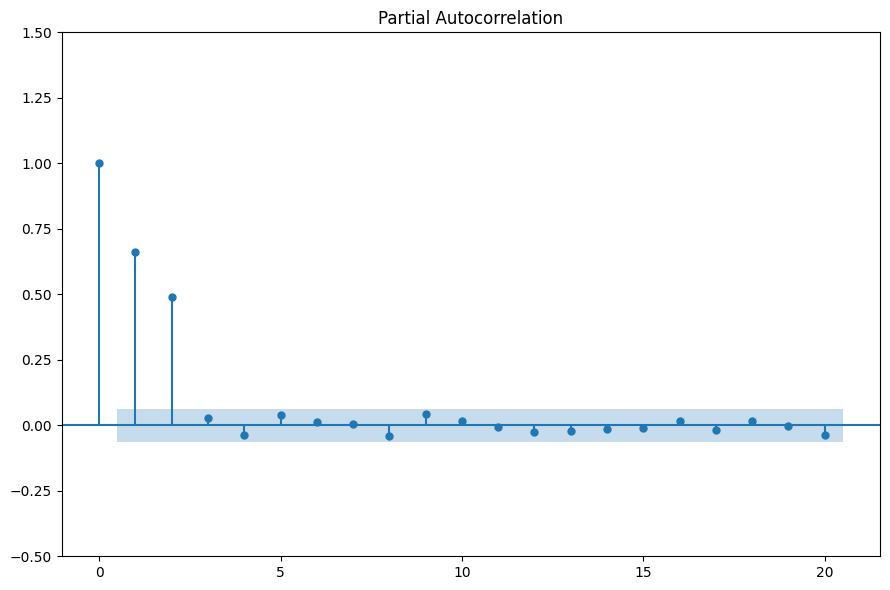

In [79]:
plot_pacf(AR2_process, lags=20);

plt.ylim(-0.5, 1.5)
plt.tight_layout()

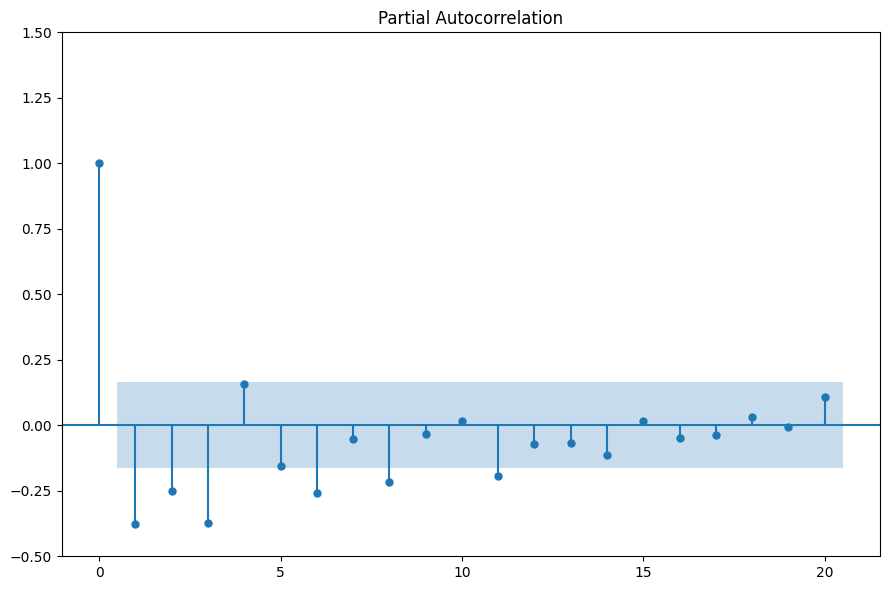

In [80]:
plot_pacf(diff_sales, lags=20);

plt.ylim(-0.5, 1.5)
plt.tight_layout()

## Forecasting with AR(p)

In [81]:
ar_model = ARIMA(order=(3, 1, 0), season_length=1, alias='AR')

sf = StatsForecast(models=[ma_model, ar_model], freq='W')
cv_df = sf.cross_validation(h=horizon, 
                            df=df, 
                            n_windows=10, 
                            step_size=horizon, 
                            level=[80], 
                            time_col='Date', 
                            id_col='Store', 
                            target_col='Weekly_Sales')

cv_df.head()

,Store,Date,cutoff,Weekly_Sales,MA,MA-lo-80,MA-hi-80,AR,AR-lo-80,AR-hi-80
0,1,2012-01-27,2012-01-20,1.319e+06,1.606e+06,1.390e+06,1.823e+06,1.453e+06,1.236e+06,1.669e+06
1,1,2012-02-03,2012-01-20,1.636e+06,1.606e+06,1.385e+06,1.827e+06,1.474e+06,1.240e+06,1.709e+06
2,1,2012-02-10,2012-01-20,1.802e+06,1.606e+06,1.380e+06,1.832e+06,1.459e+06,1.213e+06,1.705e+06
3,1,2012-02-17,2012-01-20,1.820e+06,1.606e+06,1.376e+06,1.837e+06,1.440e+06,1.185e+06,1.695e+06
4,1,2012-02-24,2012-02-17,1.539e+06,1.654e+06,1.435e+06,1.873e+06,1.644e+06,1.424e+06,1.863e+06


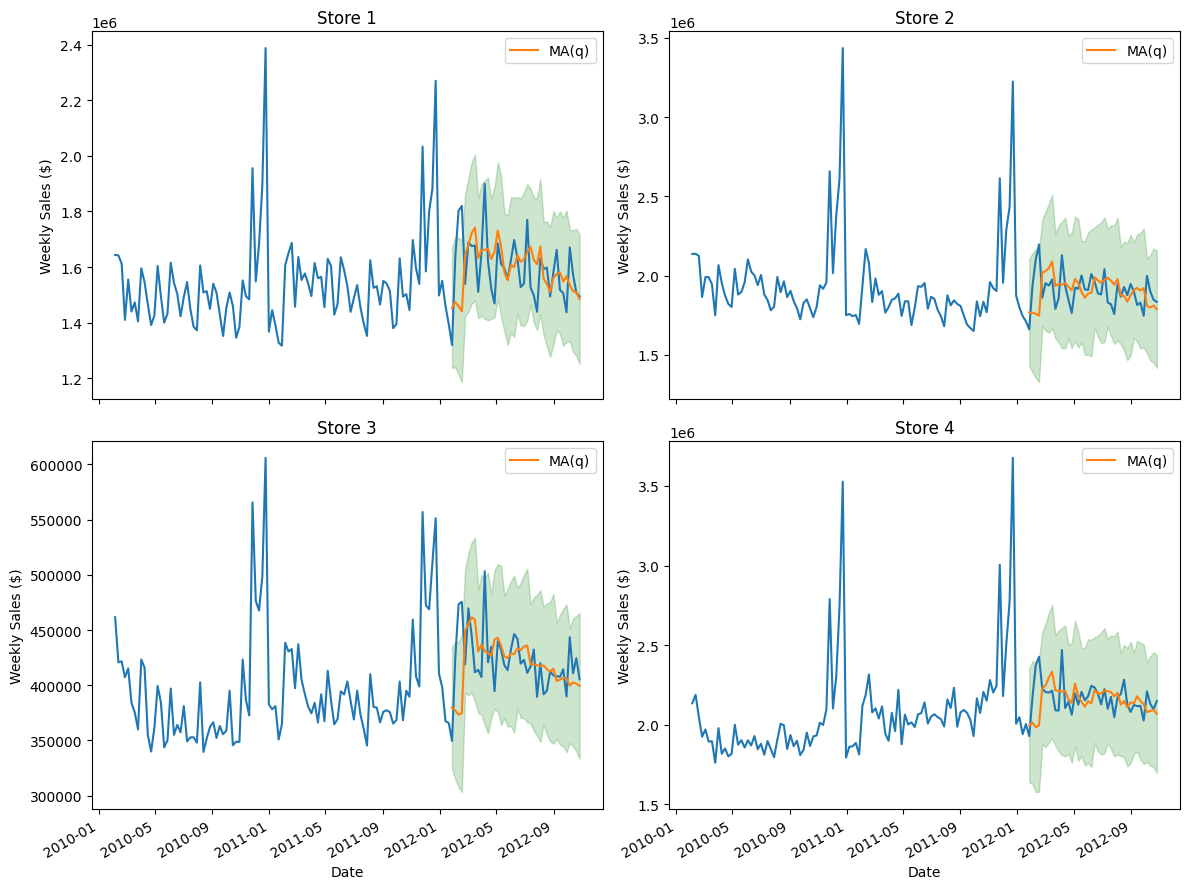

In [82]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,9))

for i, ax in enumerate(axes.flatten()):
    plot_df = df[df['Store'] == i+1]
    cv_plot_df = cv_df[cv_df['Store'] == i+1]

    ax.plot(plot_df['Date'], plot_df['Weekly_Sales'])
    ax.plot(cv_plot_df['Date'], cv_plot_df['AR'], label='AR(p)')
    ax.fill_between(cv_plot_df['Date'], cv_plot_df['AR-lo-80'], cv_plot_df['AR-hi-80'], color='green', alpha=0.2)
    ax.legend()
    ax.set_title(f'Store {i+1}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Weekly Sales ($)')

fig.autofmt_xdate()
plt.tight_layout()

In [83]:
eval_df = cv_df.drop(['Date', 'cutoff'], axis=1)
evaluation = evaluate(df=eval_df, metrics=[mae, smape], target_col='Weekly_Sales', id_col='Store')
avg_evaluation = evaluation.drop(['Store'], axis=1).groupby('metric').mean().reset_index()
avg_evaluation

,metric,MA,AR
0,mae,70615.102,76862.483
1,smape,0.024,0.026


# Forecasting with ARIMA (AutoARIMA)

In [84]:
auto_arima_model = AutoARIMA(d=1,
                             max_p=5,
                             max_q=5,
                             max_d=2,
                             start_p=0,
                             start_q=0,
                             season_length=1)

sf = StatsForecast(models=[ma_model, ar_model, auto_arima_model], freq='W')
cv_df = sf.cross_validation(h=horizon, 
                            df=df, 
                            n_windows=10, 
                            step_size=horizon, 
                            level=[80], 
                            time_col='Date', 
                            id_col='Store', 
                            target_col='Weekly_Sales')

cv_df.head()

,Store,Date,cutoff,Weekly_Sales,MA,MA-lo-80,MA-hi-80,AR,AR-lo-80,AR-hi-80,AutoARIMA,AutoARIMA-lo-80,AutoARIMA-hi-80
0,1,2012-01-27,2012-01-20,1.319e+06,1.606e+06,1.390e+06,1.823e+06,1.453e+06,1.236e+06,1.669e+06,1.533e+06,1.323e+06,1.744e+06
1,1,2012-02-03,2012-01-20,1.636e+06,1.606e+06,1.385e+06,1.827e+06,1.474e+06,1.240e+06,1.709e+06,1.574e+06,1.351e+06,1.797e+06
2,1,2012-02-10,2012-01-20,1.802e+06,1.606e+06,1.380e+06,1.832e+06,1.459e+06,1.213e+06,1.705e+06,1.586e+06,1.360e+06,1.811e+06
3,1,2012-02-17,2012-01-20,1.820e+06,1.606e+06,1.376e+06,1.837e+06,1.440e+06,1.185e+06,1.695e+06,1.589e+06,1.362e+06,1.816e+06
4,1,2012-02-24,2012-02-17,1.539e+06,1.654e+06,1.435e+06,1.873e+06,1.644e+06,1.424e+06,1.863e+06,1.678e+06,1.466e+06,1.889e+06


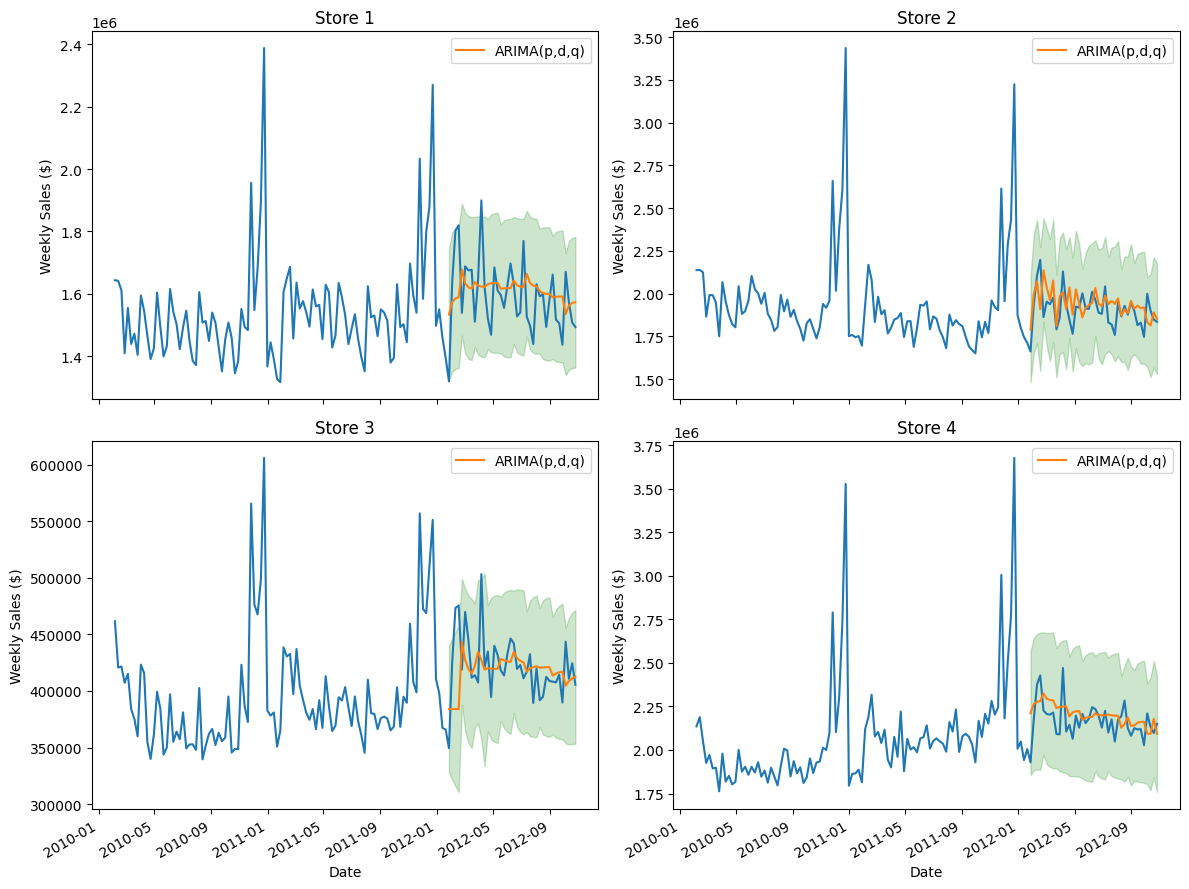

In [85]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,9))

for i, ax in enumerate(axes.flatten()):
    plot_df = df[df['Store'] == i+1]
    cv_plot_df = cv_df[cv_df['Store'] == i+1]

    ax.plot(plot_df['Date'], plot_df['Weekly_Sales'])
    ax.plot(cv_plot_df['Date'], cv_plot_df['AutoARIMA'], label='ARIMA(p,d,q)')
    ax.fill_between(cv_plot_df['Date'], cv_plot_df['AutoARIMA-lo-80'], cv_plot_df['AutoARIMA-hi-80'], color='green', alpha=0.2)
    ax.legend()
    ax.set_title(f'Store {i+1}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Weekly Sales ($)')

fig.autofmt_xdate()
plt.tight_layout()

In [86]:
eval_df = cv_df.drop(['Date', 'cutoff'], axis=1)
evaluation = evaluate(df=eval_df, metrics=[mae, smape], target_col='Weekly_Sales', id_col='Store')
avg_evaluation = evaluation.drop(['Store'], axis=1).groupby('metric').mean().reset_index()
avg_evaluation

,metric,MA,AR,AutoARIMA
0,mae,70615.102,76862.483,69734.796
1,smape,0.024,0.026,0.024
